![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Numerical Methods in Geotechnical Engineering**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/fakultaet3/gt/soilmechanics


# Exercise 2 - Backward Euler, Picard iterations

The ODE $\dot{y} = k (y_\text{eq} - y)$ is to be integrated numerically.

First, we import some libraries for numerical basics and for plotting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Some plot settings
plt.style.use('seaborn-deep')
plt.rcParams['lines.linewidth']= 2.0
plt.rcParams['lines.color']= 'black'
plt.rcParams['legend.frameon']=True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['legend.fontsize']=14
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = (8, 6)

We first code the analytical solution of the ODE in order to have something to compare against.

$\displaystyle \frac{\text{d}y}{y_\text{eq}-y} = k\,\text{d}t \quad \rightarrow \quad \int \limits_0^t k\,\text{d}\bar{t} = \int \limits_{y_0}^y \displaystyle \frac{\text{d}\bar{y}}{y_\text{eq}-\bar{y}}$

$kt = \displaystyle \left. - \ln (y_\text{eq}-\bar{y}) \right|^y_{y_0}$

$\exp (-kt) = \displaystyle \frac{y_\text{eq}-y}{y_\text{eq}-y_0}$

$y = y_\text{eq} - (y_\text{eq} - y_0) \exp (-kt)$

Let's define the equilibrium value and the rate constant as global variables

In [2]:
y_eq = 1.
k = 2.

In [3]:
def y_analytical(t,y_0):
    return y_eq - (y_eq - y_0)*np.exp(-k*t)

According to the ODE definition $\dot{y}=f[y(t),t]$ we define the rate function itself:

In [4]:
def dy_dt(y):
    return k*(y_eq - y)

Let's plot the function and its rate for some exemplary values ($y_0 = 0$) in a time interval $t \in [0,4]$:

In [5]:
time = np.linspace(0,4,100)

Text(0, 0.5, '$y$, $\\dot{y}$ / s$^{-1}$')

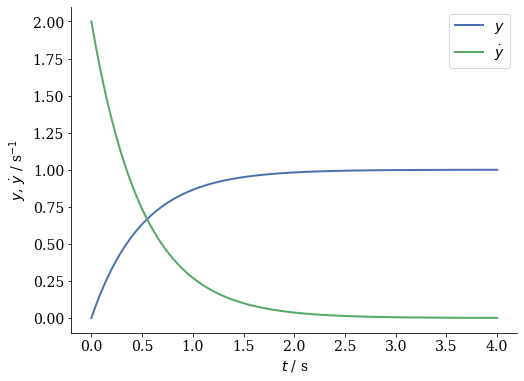

In [6]:
plt.plot(time,y_analytical(time,0),label='$y$')
plt.plot(time,dy_dt(y_analytical(time,0)),label='$\\dot{y}$')
plt.legend()
plt.xlabel('$t$ / s')
plt.ylabel('$y$, $\\dot{y}$ / s$^{-1}$')

Now we want to get the same result with a backward Euler scheme. The backward Euler scheme proceeds fully implicitly with the *recursive* update formula

$y_{n+1}^{i+1} = y_n + f(y_{n+1}^i) (t_{n+1} - t_n)$

We define the backward Euler update as

$\Delta y_\text{BE}^{i} = y_{n+1}^{i+1} - y_n = f(y_{n+1}^i) \Delta t$

In [7]:
def Backward_Euler_Update(y_i,dt):
    return dy_dt(y_i)*dt

This looks exactly like what we had for the forward Euler. The first backward Euler step will in fact be exactly the same as a forward Euler step. But we do not stop there.

We now need to define the time stepping itself. So we choose a time-step size and the same starting value (initial condition) of $y_0 = y(t=0) = 0$ to initialize our solution field.

Now, for every time step we append to this array the value of the next time step by applying the backward Euler update rule. Each new time step value then serves as the initial condition for the following time step.

We will *recursively* re-fresh the Backward-Euler update with a new estimate for the rate until the estimated solution does not change anymore, i.e.

$\left| y_{n+1}^{i+1} - y_{n+1}^{i} \right| < \epsilon_\text{abs} \cup \left| \frac{y_{n+1}^{i+1} - y_{n+1}^{i}}{y_{n+1}^{i}} \right| < \epsilon_\text{rel}$

with suitably chosen absolute and/or relative tolerances.

For simplicity, let's set only an absolute tolerance of $10^{-6}$ here.


In [8]:
def integrate(dt):
    #Startwerte
    t_end = 4.
    absolute_tolerance = 1.e-6
    max_iter = 1000
    iteration_counter = np.array([0])
    y = np.array([0.])
    times = np.array([0.])
    #
    while times[-1]+dt < t_end: #repeat the loop as long as the final time step is below the end point
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = y[-1] #Starting value for recursive update
        i = 0
        #
        while True:
            y_new = y[-1]+Backward_Euler_Update(y_old,dt) #one backward Euler step
            i += 1
            if (np.abs(y_new - y_old) < absolute_tolerance or i > max_iter): #if change is below tolerance, stop iterations
                break
            y_old = y_new #preparation of next recursion

        y = np.append(y,y_new) #append the new found solution to the solution vector
        iteration_counter = np.append(iteration_counter,i) #store how much iterations this time step took to converge
    return times, y,iteration_counter


In [9]:
from ipywidgets import widgets
from ipywidgets import interact

@interact(dt=widgets.BoundedFloatText(value=0.1,min=1e-3,max=1,step=0.1,description='$\Delta t$ / s'))

def plot_BE(dt=0.1):
    time_n, y_n,iter = integrate(dt)
    fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(18,12))
    #solution
    ax[0][0].plot(time,y_analytical(time,0),label='analytical')
    ax[0][0].plot(time_n,y_n,label='Backward Euler',marker='d',ls=':')
    ax[0][0].legend()
    ax[0][0].set_xlabel('$t$ / s')
    ax[0][0].set_ylabel('$y$')
    #error
    ax[0][1].plot(time_n,y_n-y_analytical(time_n,0),ls=':',marker='d',label='absolute')
    ax[0][1].plot(time_n[1:],(y_n[1:]-y_analytical(time_n[1:],0))/y_analytical(time_n[1:],0),
               ls=':',marker='d',label='relative')
    ax[0][1].legend()
    ax[0][1].set_xlabel('$t$ / s')
    ax[0][1].set_ylabel('error')
    #iterations
    ax[1][0].plot(iter)
    ax[1][0].set_xlabel('time step')
    ax[1][0].set_ylabel('number of iterations')
    
    plt.show()

interactive(children=(BoundedFloatText(value=0.1, description='$\\Delta t$ / s', max=1.0, min=0.001, step=0.1)…

Tasks:

- How does the peak relative error change when you divide the time step size by 10?
- How does the solution change when you increase the rate constant by a factor of 2 and why?
- How does the solution change again for $k=4$ and time step sices of $\Delta t= 0.2$?
- What happens for $k=4$ and $\Delta t = 0.3$? How can this be fixed?
